# 1. Import Data

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import time
import datetime

#libraries for pre-processing text 
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize

#load the SentimentIntensityAnalyser object in
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# assign it to another name to make it easier to use
analyzer = SentimentIntensityAnalyzer()

#libraries for word cloud
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

#libraries for decomposition
from sklearn import decomposition 

#libraries for visualisation
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

#libraries for clustering
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import os

In [32]:
df = pd.read_csv("..//May Myo//raw_data//reviews.csv.gz")

# checking shape ...
print("The dataset has {} rows and {} columns.".format(*reviews.shape))

# ... and duplicates
print("It contains {} duplicates.".format(reviews.duplicated().sum()))

The dataset has 320628 rows and 6 columns.
It contains 0 duplicates.


In [33]:
df.head()

listing_id     id        date  reviewer_id reviewer_name  \
0         958   5977  2009-07-23        15695      Edmund C   
1         958   6660  2009-08-03        26145         Simon   
2         958  11519  2009-09-27        25839         Denis   
3         958  16282  2009-11-05        33750          Anna   
4         958  26008  2010-02-13        15416       Venetia   

                                            comments  
0  Our experience was, without a doubt, a five st...  
1  Returning to San Francisco is a rejuvenating t...  
2  We were very pleased with the accommodations a...  
3  We highly recommend this accomodation and agre...  
4  Holly's place was great. It was exactly what I...

# 2. Preprocessing the Data

In [34]:
df.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         133
dtype: int64

In [31]:
df.dropna(inplace=True)
df.isna().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [41]:
df.shape

(320628, 6)

### 3. Detect Language used in comments

In [38]:
from langdetect import detect

In [39]:
# the function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [40]:
%%time
df['language'] = reviews['comments'].apply(language_detection)

Wall time: 1h 2min 16s


In [42]:
df.language.value_counts().head(10)

en       298505
fr         6327
de         3648
es         2935
zh-cn      1878
ko         1553
ro          735
it          710
pt          535
nl          516
Name: language, dtype: int64

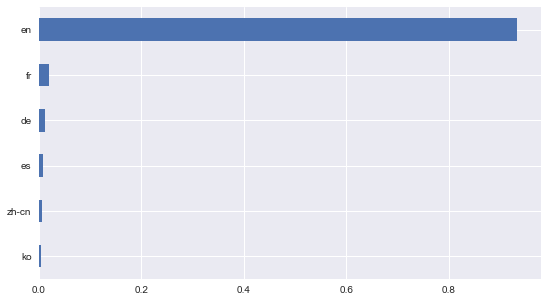

In [47]:
ax = df.language.value_counts(normalize=True).head(6).sort_values().plot(kind='barh', figsize=(9,5));

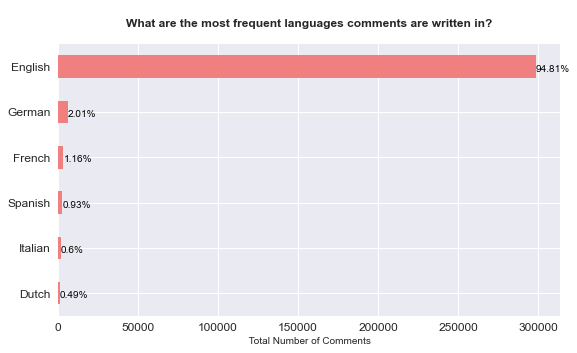

In [48]:
# visualizing the comments' languages b) neat and clean
ax = df.language.value_counts().head(6).plot(kind='barh', figsize=(9,5), color="lightcoral", 
                                             fontsize=12);

ax.set_title("\nWhat are the most frequent languages comments are written in?\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Total Number of Comments", fontsize=10)
ax.set_yticklabels(['English', 'German', 'French', 'Spanish', 'Italian', 'Dutch'])

# create a list to collect the plt.patches data
totals = []
# find the ind. values and append to list
for i in ax.patches:
    totals.append(i.get_width())
# get total
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    ax.text(x=i.get_width(), y=i.get_y()+.35, 
            s=str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')

# invert for largest on top 
ax.invert_yaxis()

In [64]:
# as we are only interested in comments written in english, we need to split the data to english related sub-dataframes
df_eng = df[(df['language']=='en')]

In [60]:
#save df_eng to pkl files to reduce loading time 
reviews=reviews.drop(['language'], axis=1)
df_eng.to_pickle("df_eng.pkl")

In [74]:
df_eng.head()

listing_id     id        date  reviewer_id reviewer_name  \
0         958   5977  2009-07-23        15695      Edmund C   
1         958   6660  2009-08-03        26145         Simon   
2         958  11519  2009-09-27        25839         Denis   
3         958  16282  2009-11-05        33750          Anna   
4         958  26008  2010-02-13        15416       Venetia   

                                            comments  
0  Our experience was, without a doubt, a five st...  
1  Returning to San Francisco is a rejuvenating t...  
2  We were very pleased with the accommodations a...  
3  We highly recommend this accomodation and agre...  
4  Holly's place was great. It was exactly what I...

In [44]:
reviews = pd.read_pickle("df_eng.pkl")

In [45]:
#remove commens with 2 alphabets and less
reviews["comments_cleansed"] = reviews.comments.str.replace(r'\b(\w{1,2})\b', '')

In [46]:
#Remove non-letters and change to lower case:
stemmer = PorterStemmer()
#remove stop words, tokenise the text data
stop_words = set(stopwords.words('english'))

def preprocess(review):
    review = " ".join([stemmer.stem(w.lower()) for w in word_tokenize(re.sub('[^a-zA-Z]+', ' ', review.replace("<br />", ""))) if not w in stop_words])
    return review

reviews['comments_cleansed'] = reviews.apply(lambda x: preprocess(x['comments_cleansed']), axis=1)

In [80]:
#reviews = reviews.iloc[:, :-1]
#reviews=reviews.drop(['language'], axis=1)
reviews.head()

listing_id     id        date  reviewer_id reviewer_name  \
0         958   5977  2009-07-23        15695      Edmund C   
1         958   6660  2009-08-03        26145         Simon   
2         958  11519  2009-09-27        25839         Denis   
3         958  16282  2009-11-05        33750          Anna   
4         958  26008  2010-02-13        15416       Venetia   

                                            comments  \
0  Our experience was, without a doubt, a five st...   
1  Returning to San Francisco is a rejuvenating t...   
2  We were very pleased with the accommodations a...   
3  We highly recommend this accomodation and agre...   
4  Holly's place was great. It was exactly what I...   

                                   comments_cleansed  
0  experi without doubt five star experi holli hu...  
1  return francisco rejuven thrill time enhanc st...  
2  pleas accommod friendli neighborhood be abl ma...  
3  highli recommend accomod agre previou post hol...  
4  holli place great exactli need perfect locat s...

In [60]:
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title('Top Comments\n', fontsize=18, fontweight='bold')
    plt.show()

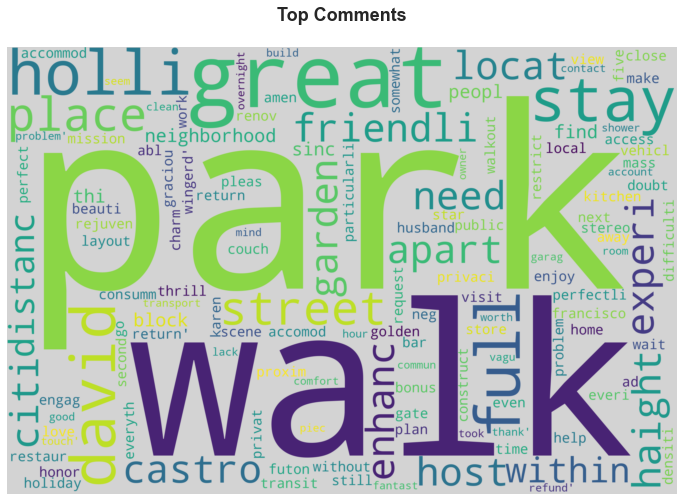

In [61]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(reviews.comments_cleansed.values))

plot_wordcloud(wordcloud, 'English')

In [47]:
my_stop_words = ["".join(reviews.comments_cleansed[idx]) for idx in reviews.index]

In [48]:
len(my_stop_words)

298505

In [49]:
vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(my_stop_words)
print("Created document-term matrix of size %d x %d" % (tfidf.shape[0],tfidf.shape[1]))

Created document-term matrix of size 298505 x 31649


In [120]:
nmf = decomposition.NMF(init = 'nndsvd', n_components = 5, max_iter = 200)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated W(document-topic)) matrix of size %s and H (topic-word) matrix of size %s" % ( str(W.shape), str(H.shape)))

feature_names = vectorizer.get_feature_names()
n_top_words = 10

# Print top words in each topic
for topic_idx, topic in enumerate(H):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Generated W(document-topic)) matrix of size (298505, 5) and H (topic-word) matrix of size (5, 30580)
Topic #0:
easi park walk space quiet neighborhood restaur distanc access commun

Topic #1:
host respons help highli commun space autom cancel post reserv

Topic #2:
veri cozi quiet respons help spaciou privat cute stylish hospit

Topic #3:
home realli hous beauti time francisco like help thi view

Topic #4:
apart highli spaciou beauti francisco view equip help mission restaur



In [57]:
reviews.head()

listing_id     id        date  reviewer_id reviewer_name  \
0         958   5977  2009-07-23        15695      Edmund C   
1         958   6660  2009-08-03        26145         Simon   
2         958  11519  2009-09-27        25839         Denis   
3         958  16282  2009-11-05        33750          Anna   
4         958  26008  2010-02-13        15416       Venetia   

                                            comments  \
0  Our experience was, without a doubt, a five st...   
1  Returning to San Francisco is a rejuvenating t...   
2  We were very pleased with the accommodations a...   
3  We highly recommend this accomodation and agre...   
4  Holly's place was great. It was exactly what I...   

                                   comments_cleansed  \
0  experi without doubt five star experi holli hu...   
1  return francisco rejuven thrill time enhanc st...   
2  pleas accommod friendli neighborhood be abl ma...   
3  highli recommend accomod agre previou post hol...   
4  holli place great exactli need perfect locat s...   

                                    comments_cleaned  
0  our experi without doubt five star experi holl...  
1  return san francisco rejuven thrill time enhan...  
2  we pleas accommod friendli neighborhood be abl...  
3  we highli recommend accomod agre previou post ...  
4  holli place great it exactli i need perfect lo...

In [121]:
mydf = pd.DataFrame({"feature_name": feature_names})

for topic_idx, topic in enumerate(H):
    mydf["topic_" + str(topic_idx)] = topic

mylist = list(mydf.itertuples())

reviews_topic1 = []
reviews_topic2 = []
reviews_topic3 = []
reviews_topic4 = []
reviews_topic5 = []

for order_id, key, num1, num2, num3, num4, num5 in mylist:
    reviews_topic1.append((key, num1))
    reviews_topic2.append((key, num2))
    reviews_topic3.append((key, num3))
    reviews_topic4.append((key, num4))
    reviews_topic5.append((key, num5))

reviews_topic1 = sorted(reviews_topic1, key=lambda myword: myword[1], reverse=True)
reviews_topic2 = sorted(reviews_topic2, key=lambda myword: myword[1], reverse=True)
reviews_topic3 = sorted(reviews_topic3, key=lambda myword: myword[1], reverse=True)
reviews_topic4 = sorted(reviews_topic4, key=lambda myword: myword[1], reverse=True)
reviews_topic5 = sorted(reviews_topic5, key=lambda myword: myword[1], reverse=True)

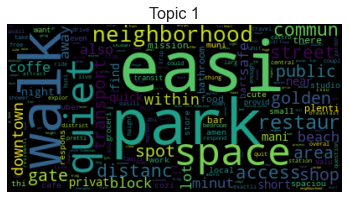

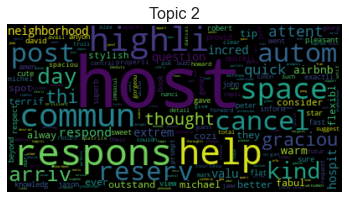

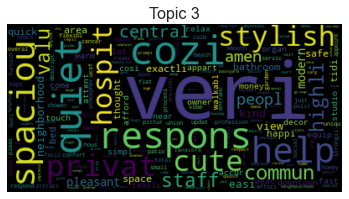

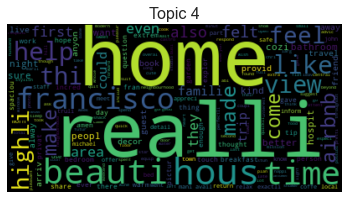

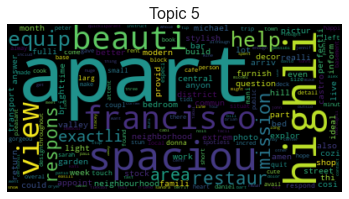

In [122]:
%matplotlib inline

def draw_wordcloud(dict, topic_number):
    wc = WordCloud(max_words=1000)    
    wordcloud = WordCloud().generate_from_frequencies(dict)
    
    plt.title('Topic %s' %str(topic_number), size = 16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")        
    plt.show()

draw_wordcloud(dict(reviews_topic1), topic_number=1)
draw_wordcloud(dict(reviews_topic2), topic_number=2)
draw_wordcloud(dict(reviews_topic3), topic_number=3)
draw_wordcloud(dict(reviews_topic4), topic_number=4)
draw_wordcloud(dict(reviews_topic5), topic_number=5)

In [119]:
reviews.comments_cleansed.str.split(expand=True).stack().value_counts()[:30]

stay         201204
great        197922
place        181495
locat        124787
clean         98634
host          96100
room          75487
nice          73984
would         72746
recommend     72612
comfort       66779
love          61832
apart         59129
home          55122
walk          51498
everyth       51279
park          50872
need          50847
easi          50223
realli        48661
perfect       47629
time          46736
hous          45808
francisco     45584
well          44024
definit       43824
good          43500
citi          42495
space         41893
help          41420
dtype: int64

In [23]:
# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [78]:
%%time

reviews['sentiment_neg'] = reviews['comments'].apply(negative_score)
reviews['sentiment_neu'] = reviews['comments'].apply(neutral_score)
reviews['sentiment_pos'] = reviews['comments'].apply(positive_score)
reviews['sentiment_compound'] = reviews['comments'].apply(compound_score)

Wall time: 31min 45s


In [84]:
df = reviews
df=df.drop(['reviewer_id'], axis=1)
df=df.drop(['reviewer_name'], axis=1)
df=df.drop(['date'], axis=1)

In [3]:
#df.to_pickle("df_sentiment.pkl")
df =pd.read_pickle("df_sentiment.pkl")

In [4]:
df.head()

listing_id     id                                           comments  \
0         958   5977  Our experience was, without a doubt, a five st...   
1         958   6660  Returning to San Francisco is a rejuvenating t...   
2         958  11519  We were very pleased with the accommodations a...   
3         958  16282  We highly recommend this accomodation and agre...   
4         958  26008  Holly's place was great. It was exactly what I...   

                                   comments_cleansed  sentiment_neg  \
0  experi without doubt five star experi holli hu...          0.000   
1  return francisco rejuven thrill time enhanc st...          0.000   
2  pleas accommod friendli neighborhood be abl ma...          0.134   
3  highli recommend accomod agre previou post hol...          0.035   
4  holli place great exactli need perfect locat s...          0.000   

   sentiment_neu  sentiment_pos  sentiment_compound  
0          0.788          0.212              0.9590  
1          0.697          0.303              0.9819  
2          0.710          0.156              0.7600  
3          0.646          0.319              0.9840  
4          0.613          0.387              0.9617

In [5]:
def label_sentiment (df):
    if df['sentiment_compound'] >= 0.05 :
        return 1
    return 0

def sentiment_type (df):
    if df['sentiment_compound'] >= 0.05 :
        return "positive"
    if df['sentiment_compound'] >= -0.05 :
        return "neutral"
    if df['sentiment_compound'] <= -0.05 :
        return "negative"

In [6]:
df['sentiment_label'] = df.apply(label_sentiment, axis=1)

df['sentiment_type'] = df.apply(label_sentiment, axis=1)

In [54]:
df.head

<bound method NDFrame.head of         listing_id         id  \
0              958       5977   
1              958       6660   
2              958      11519   
3              958      16282   
4              958      26008   
...            ...        ...   
320623    44554195  649112168   
320624    44554195  649140249   
320625    44554195  649170022   
320626    44554195  649218478   
320627    44554195  649614164   

                                                 comments  \
0       Our experience was, without a doubt, a five st...   
1       Returning to San Francisco is a rejuvenating t...   
2       We were very pleased with the accommodations a...   
3       We highly recommend this accomodation and agre...   
4       Holly's place was great. It was exactly what I...   
...                                                   ...   
320623  Cute, updated hotel in a very central area. Ea...   
320624  Skip this air bnb. To many cons . you won't en...   
320625                  

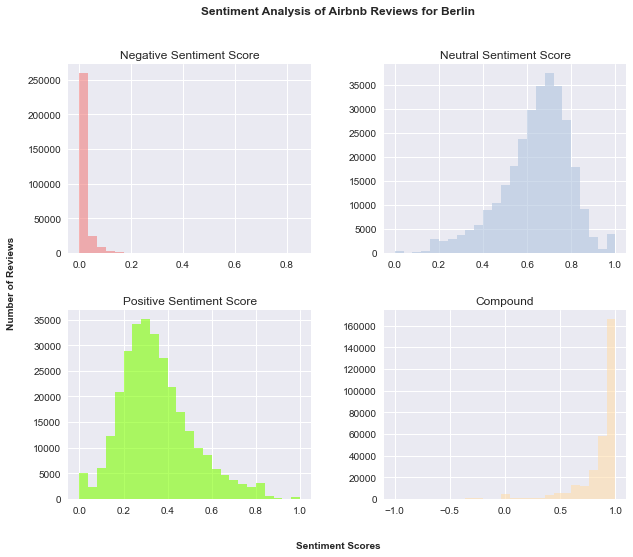

In [14]:
# all scores in 4 histograms
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# plot all 4 histograms
df.hist('sentiment_neg', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
axes[0,0].set_title('Negative Sentiment Score')
df.hist('sentiment_neu', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
axes[0,1].set_title('Neutral Sentiment Score')
df.hist('sentiment_pos', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')
df.hist('sentiment_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
axes[1,1].set_title('Compound')

# plot common x- and y-label
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Reviews', fontweight='bold', va='center', rotation='vertical')

# plot title
plt.suptitle('Sentiment Analysis of Airbnb Reviews for Berlin\n\n', fontsize=12, fontweight='bold');

In [26]:
percentiles = df.sentiment_compound.describe(percentiles=[0.01, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9])
percentiles

count    298505.000000
mean          0.855578
std           0.218185
min          -0.997800
1%            0.000000
5%            0.457400
10%           0.636100
20%           0.801600
30%           0.868700
40%           0.907800
50%           0.932400
60%           0.950100
70%           0.963600
80%           0.974400
90%           0.984200
max           0.999700
Name: sentiment_compound, dtype: float64

In [7]:
# full dataframe with POSITIVE comments
df_pos = df.loc[df.sentiment_compound >= 0.95]

# only corpus of POSITIVE comments
pos_comments = df_pos['comments'].tolist()

In [19]:
# full dataframe with NEGATIVE comments
df_neg = df.loc[df.sentiment_compound <= -0.05]

# only corpus of NEGATIVE comments
neg_comments = df_neg['comments'].tolist()

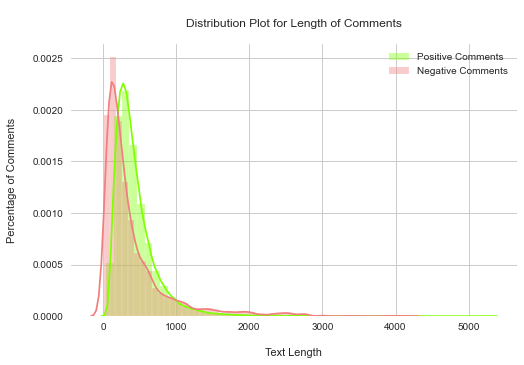

In [20]:
df_pos['text_length'] = df_pos['comments'].apply(len)
df_neg['text_length'] = df_neg['comments'].apply(len)
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df_pos['text_length'], kde=True, bins=50, color='chartreuse')
sns.distplot(df_neg['text_length'], kde=True, bins=50, color='lightcoral')

plt.title('\nDistribution Plot for Length of Comments\n')
plt.legend(['Positive Comments', 'Negative Comments'])
plt.xlabel('\nText Length')
plt.ylabel('Percentage of Comments\n');

In [34]:
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()

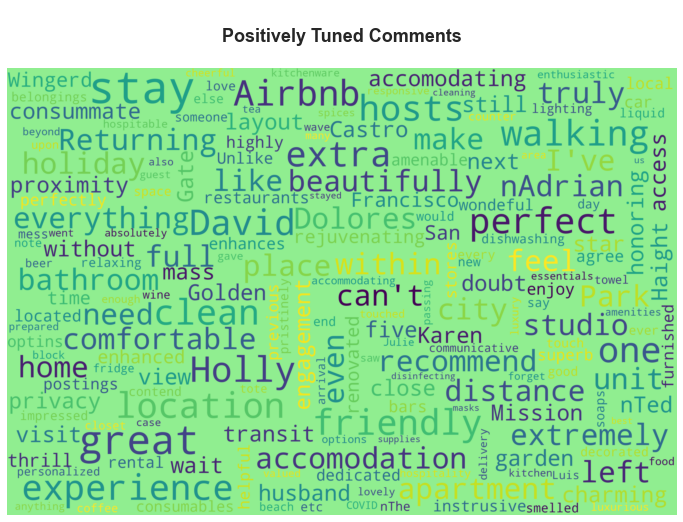

In [36]:
wordcloud = WordCloud(max_font_size=200, max_words=200, background_color="lightgreen",
                      width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(df_pos.comments.values))

plot_wordcloud(wordcloud, '\nPositively Tuned')

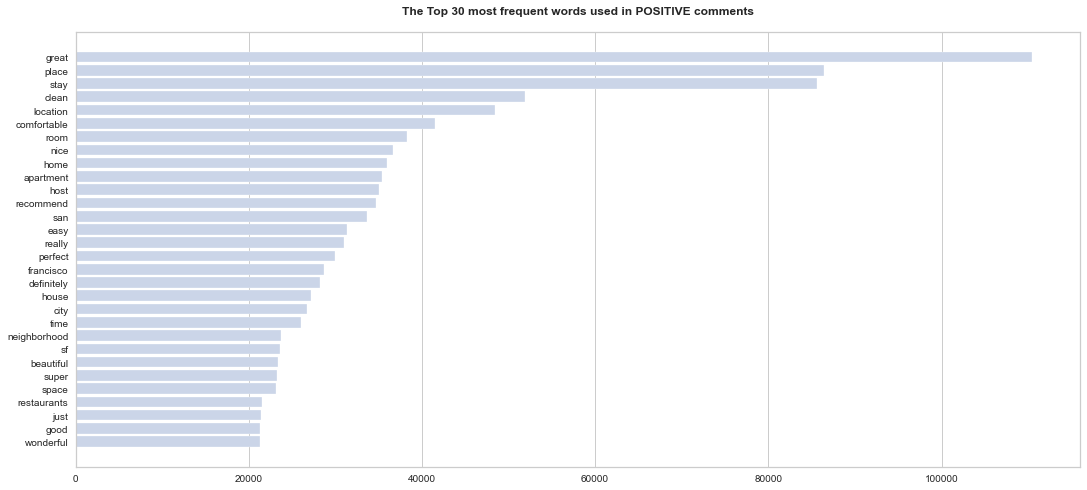

In [100]:
# vectorizing text
vectorizer2 = CountVectorizer(stop_words='english')
docs = vectorizer2.fit_transform(pos_comments)
features = vectorizer2.get_feature_names()

# preparing the plot
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in POSITIVE comments\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(docs)
visualizer.poof;

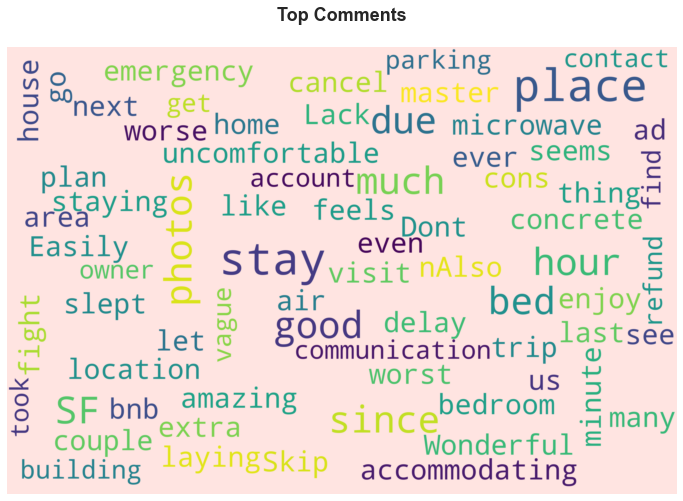

In [101]:
wordcloud = WordCloud(max_font_size=200, max_words=200, background_color="mistyrose",
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(df_neg.comments.values))

plot_wordcloud(wordcloud, '\nNegatively Tuned')

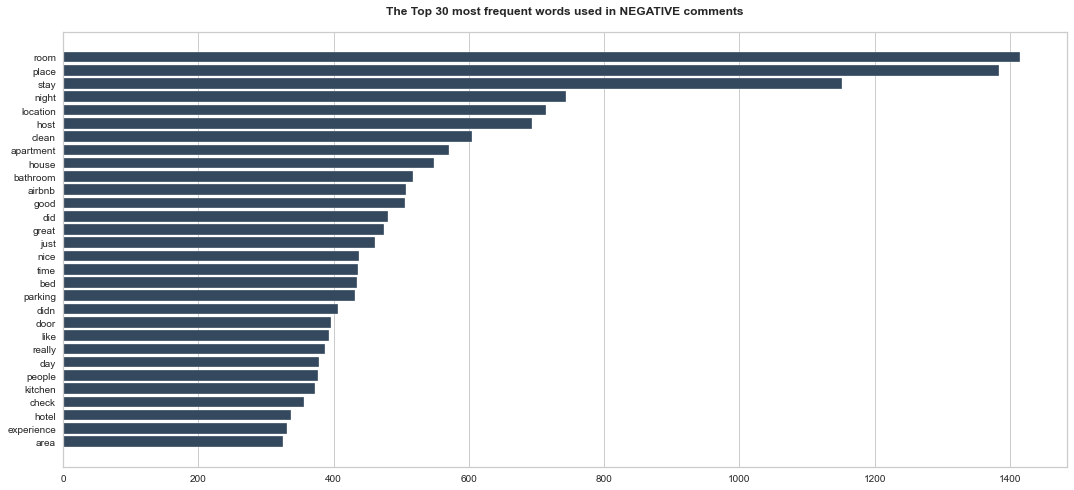

In [103]:
# vectorizing text
vectorizer3 = CountVectorizer3(stop_words='english')
docs = vectorizer3.fit_transform(neg_comments)
features = vectorizer3.get_feature_names()

# preparing the plot
set_palette('flatui')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in NEGATIVE comments\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(docs)
visualizer.poof;

### Clustering

In [2]:
#reviews = reviews.to_pickle("reviews.pkl")
reviews = pd.read_pickle("reviews.pkl")

In [3]:
my_stop_words = ["".join(reviews.comments_cleansed[idx]) for idx in reviews.index]

In [4]:
#display the comment and count of comment
reviews.comments_cleansed[0:90000].str.split(expand=True).stack().value_counts()[3490:3500]

da         27
outdat     27
same       27
gay        27
perform    27
larri      27
makeup     27
retro      27
coff       27
vey        27
dtype: int64

In [5]:
#reduction of the review list due to lack of computation power
vectorizer_r = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words =  my_stop_words[0:90000], max_features = 3500)

tfidf_r = vectorizer_r.fit_transform(my_stop_words[0:90000])
print("Created document-term matrix of size %d x %d" % (tfidf_r.shape[0],tfidf_r.shape[1]))

tf_idf_norm = normalize(tfidf_r)

tf_idf_array = tf_idf_norm.toarray()

Created document-term matrix of size 90000 x 3500


In [28]:
w2v = pd.DataFrame(tf_idf_array, columns=vectorizer_r.get_feature_names()).head()

In [29]:
w2v.head()

aaron  abhay  abil       abl  abod  abound  about  abov  abroad  absenc  \
0    0.0    0.0   0.0  0.000000   0.0     0.0    0.0   0.0     0.0     0.0   
1    0.0    0.0   0.0  0.000000   0.0     0.0    0.0   0.0     0.0     0.0   
2    0.0    0.0   0.0  0.097224   0.0     0.0    0.0   0.0     0.0     0.0   
3    0.0    0.0   0.0  0.000000   0.0     0.0    0.0   0.0     0.0     0.0   
4    0.0    0.0   0.0  0.000000   0.0     0.0    0.0   0.0     0.0     0.0   

   ...  younger  your   yr  yum  yummi  zazi  zen  zero  zone  zoo  
0  ...      0.0   0.0  0.0  0.0    0.0   0.0  0.0   0.0   0.0  0.0  
1  ...      0.0   0.0  0.0  0.0    0.0   0.0  0.0   0.0   0.0  0.0  
2  ...      0.0   0.0  0.0  0.0    0.0   0.0  0.0   0.0   0.0  0.0  
3  ...      0.0   0.0  0.0  0.0    0.0   0.0  0.0   0.0   0.0  0.0  
4  ...      0.0   0.0  0.0  0.0    0.0   0.0  0.0   0.0   0.0  0.0  

[5 rows x 3500 columns]

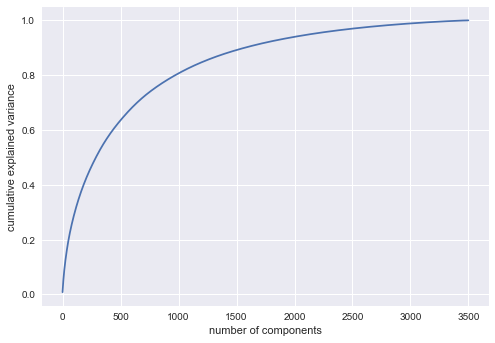

In [30]:
pca = PCA().fit(tf_idf_array)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [6]:
#as 1000 component covers 80% but it takes another 500 to cover just 10% we pick 1000 components
sklearn_pca = PCA(n_components = 1000)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

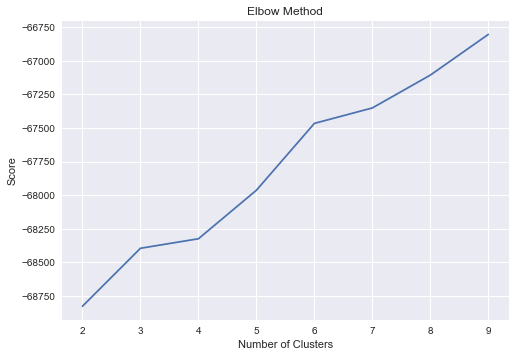

In [8]:
number_clusters = range(2, 10)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

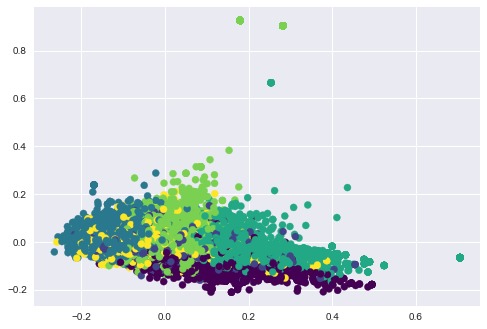

In [9]:
kmeans = KMeans(n_clusters=6, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

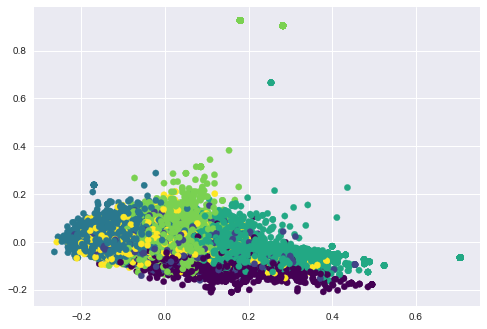

In [30]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis')
# centers = fitted.centroids
# plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

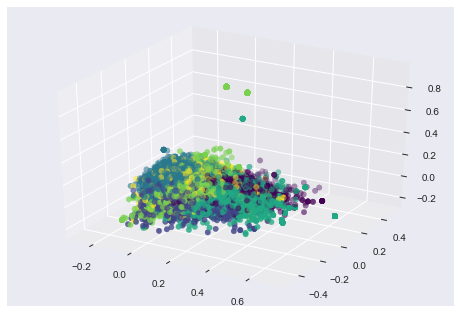

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter( Y_sklearn[:, 0], Y_sklearn[:, 2], Y_sklearn[:, 1], zdir='z', s=30, c=prediction, cmap='viridis')

In [34]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer_r.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 10)

In [35]:
dfs

[  features     score
 0    sarah  0.411642
 1    roman  0.130999
 2    apart  0.058108
 3      the  0.044495
 4     home  0.030997
 5     host  0.028027
 6    would  0.027939
 7      san  0.023482
 8  restaur  0.023408
 9     need  0.022988,
    features     score
 0      room  0.108923
 1      hous  0.090225
 2       the  0.081436
 3      host  0.035934
 4    realli  0.031934
 5      good  0.027952
 6  bathroom  0.026106
 7     would  0.026017
 8       bed  0.025362
 9    beauti  0.024710,
   features     score
 0     host  0.052562
 1     home  0.032696
 2    would  0.030140
 3   wonder  0.026271
 4      the  0.024220
 5     time  0.022576
 6  definit  0.021853
 7     help  0.021590
 8   beauti  0.021560
 9   highli  0.021240,
        features     score
 0           the  0.068814
 1         apart  0.064579
 2          walk  0.045605
 3          park  0.043801
 4       restaur  0.038684
 5          easi  0.036062
 6         close  0.034298
 7  neighborhood  0.031433
 8         quiet 

In [31]:
def extract_sentiment(results):
    k = 0
    for sentiment in results:
        if k == 0 or results[sentiment] > results[k]:
            k = sentiment

    if k == 'neu':
        return 'neutral'
    elif k == 'pos':
        return 'positive'
    elif k == 'neg':
        return 'negative'

    return 'n/a'

def get_prevalent_element(elements):
    max_count_element = elements[0]
    for element in elements:
        if elements.count(element) > elements.count(max_count_element):
            max_count_element = element
    return max_count_element

In [36]:
validation_score = silhouette_score(tfidf_r, cluster_labels)

print(validation_score)

0.010260296200966456


In [65]:
num_clusters = 6
# use k means to cluster vectorized sentences
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=150)
kmeans_model.fit(Y_sklearn)
cluster_labels = kmeans_model.fit_predict(Y_sklearn)

# get centroids for each cluster
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]

# get { word, vectorized_word } or human-word per word-vector
terms = vectorizer_r.get_feature_names()

# dictionary - array of { cluster_number: [word-vector] }
human_clusters = []
cluster_sentiments = []

# start of vader sentiment analyzer
# initialize sentiment analyzer instance
sentiment_analyzer = SentimentIntensityAnalyzer()

# populate human clusters with array of [human-words] with index as cluster label
for i in range(num_clusters):
    cluster = []
    sentiments = []
    # in every cluster, get 8 nearest words
    for word_index in order_centroids[i, :6]:
        # reveal human word from terms[word_vector]
        human_word = terms[word_index]
        # append the word to the cluster
        cluster.append(human_word)

    for word_index in order_centroids[i, :]:
        human_word = terms[word_index]
        # get sentiment from VADER sentiment analyzer
        sentiment = sentiment_analyzer.polarity_scores(human_word)
        # append the resulting sentiment to the sentiment array
        sentiments.append(extract_sentiment(sentiment))

    human_clusters.append(cluster)
    # append only the prevalent element to the sentiment array
    cluster_sentiments.append(get_prevalent_element(sentiments))

validation_score = silhouette_score(tfidf_r, cluster_labels)

# create a in-memory worksheet containing Cluster, Words, Prevalent Sentiment, and Silhouette Score
df = pd.DataFrame({'Cluster': range(1, len(human_clusters) + 1),
                   'Words': human_clusters,
                   'Prevalent Sentiment': cluster_sentiments,
                   'Silhouette Score': validation_score})

In [66]:
df

Cluster                                              Words  \
0        1       [abound, abov, abl, academi, access, abroad]   
1        2          [abhay, aaron, absenc, abov, abound, abl]   
2        3          [abil, abod, abl, absenc, abhay, absolut]   
3        4       [abroad, abil, abov, aaron, accept, absolut]   
4        5  [about, aaron, absolutli, accommod, advantag, ...   
5        6     [aaron, abod, abl, absolutli, accept, academi]   

  Prevalent Sentiment  Silhouette Score  
0             neutral           0.01085  
1             neutral           0.01085  
2             neutral           0.01085  
3             neutral           0.01085  
4             neutral           0.01085  
5             neutral           0.01085

LDA

In [52]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, my_stop_words, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 20
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(tfidf)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, my_stop_words, number_words)

Topics found via LDA:

Topic #0:
the room park night apart bed peopl bathroom realli littl price get time bit one host hous space street area

Topic #1:
host home beauti the view space hous time thi realli apart san highli friendli francisco room neighborhood airbnb feel help

Topic #2:
the close walk park restaur easi veri quiet neighborhood host transport citi apart public golden gate distanc san area room

Topic #3:
host easi the check highli commun veri apart san realli francisco help room respons quick spot friendli space fantast describ

Topic #4:
the room arriv host day coffe bed even check thi also realli reserv help provid time apart breakfast post like


In [62]:
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(6))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, tfidf, vectorizer)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(6) +'.html')

In [39]:
pip install pyLDAvis


  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97716 sha256=7125c8c77d9cc22ef71df1da6ecf06f23bf9e9504fc322d6f6eca1256c8c8697
  Stored in directory: c:\users\tanny\appdata\local\pip\cache\wheels\31\8c\a0\24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
Successfully built pyLDAvis
